<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import" data-toc-modified-id="Import-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import</a></span></li><li><span><a href="#Data-Cleaning" data-toc-modified-id="Data-Cleaning-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Cleaning</a></span></li><li><span><a href="#處理缺失值" data-toc-modified-id="處理缺失值-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>處理缺失值</a></span></li><li><span><a href="#視覺化" data-toc-modified-id="視覺化-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>視覺化</a></span></li><li><span><a href="#Feature-Engineering" data-toc-modified-id="Feature-Engineering-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Feature Engineering</a></span></li><li><span><a href="#Auto-Feature-Engineering--自動化特徵工程" data-toc-modified-id="Auto-Feature-Engineering--自動化特徵工程-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Auto Feature Engineering  自動化特徵工程</a></span></li><li><span><a href="#Feature-Selection-特徵選擇" data-toc-modified-id="Feature-Selection-特徵選擇-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Feature Selection 特徵選擇</a></span></li><li><span><a href="#根據測試資料集的自動化特徵工程" data-toc-modified-id="根據測試資料集的自動化特徵工程-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>根據測試資料集的自動化特徵工程</a></span></li><li><span><a href="#建立模型" data-toc-modified-id="建立模型-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>建立模型</a></span></li><li><span><a href="#建立自動化的找尋最佳超參數" data-toc-modified-id="建立自動化的找尋最佳超參數-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>建立自動化的找尋最佳超參數</a></span></li></ul></div>

1. fullVisitorId- A unique identifier for each user of the Google Merchandise Store.
2. channelGrouping - The channel via which the user came to the Store.
3. date - The date on which the user visited the Store.
4. device - The specifications for the device used to access the Store.
5. geoNetwork - This section contains information about the geography of the user.
6. sessionId - A unique identifier for this visit to the store.
7. socialEngagementType - Engagement type, either "Socially Engaged" or "Not Socially Engaged".
8. totals - This section contains aggregate values across the session.
9. trafficSource - This section contains information about the Traffic Source from which the session originated.
10. visitId - An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.
11. visitNumber - The session number for this user. If this is the first session, then this is set to 1.
12. visitStartTime - The timestamp (expressed as POSIX time).


Removed Data Fields

Some fields were censored to remove target leakage. The major censored fields are listed below.

1. hits - This row and nested fields are populated for any and all types of hits. Provides a record of all page visits.
2. customDimensions - This section contains any user-level or session-level custom dimensions that are set for a session. This is a repeated field and has an entry for each dimension that is set.
3. totals - Multiple sub-columns were removed from the totals field.

## Import 

In [22]:
import os
print(os.listdir(r"/Users/jacky/Kaggle/Google Analytics Customer Revenue Prediction/all-5"))

import time
import gc
import warnings
warnings.filterwarnings('ignore')

#data manipulation
import json
from pandas.io.json import json_normalize
import numpy as np
import pandas as pd

#plot 
import matplotlib.pyplot as plt
import seaborn as sns
color=sns.color_palette()

#model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

from matplotlib.font_manager import _rebuild
_rebuild()
#防止中文乱码问题
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

['test.csv', 'train.csv', 'sample_submission.csv']


## Data Cleaning 

In [68]:
def load_df(csv_path, nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']

    df = pd.read_csv(csv_path,
                     converters={
                         column: json.loads for column in JSON_COLUMNS},
                     dtype={'fullVisitorId': 'str'},  # Important!!
                     nrows=nrows)

    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = ["{0}.{1}".format(
            column, subcolumn) for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(
            column_as_df, right_index=True, left_index=True)
    print("Loaded {0}. Shape: {1}".format(
        os.path.basename(csv_path), df.shape))
    return df


train_df = load_df(
    '/Users/jacky/Kaggle/Google Analytics Customer Revenue Prediction/all-5/train.csv')
test_df = load_df(
    '/Users/jacky/Kaggle/Google Analytics Customer Revenue Prediction/all-5/test.csv')
train_df.to_csv('train_df')
test_df.to_csv('test_df')

Loadted train.csv. Shape: (903653, 55)
Loadted test.csv. Shape: (804684, 53)


In [612]:
train_df = pd.read_csv('train_df', index_col=None)
test_df = pd.read_csv('test_df')

In [613]:
train_df.drop('Unnamed: 0', axis=1, inplace=True)
test_df.drop('Unnamed: 0', axis=1, inplace=True)

In [614]:
set(train_df.columns).difference(test_df.columns)

{'totals.transactionRevenue', 'trafficSource.campaignCode'}

In [615]:
#將unique值放入list裡 並製成dataframe
nunique = []
for column in train_df.columns:
    nunique.append(train_df['{}'.format(column)].nunique(dropna=False))
train_df_nunique = pd.DataFrame({'nunique': nunique}, index=train_df.columns)
train_df_nunique.sort_values(by='nunique', ascending=False).head(10)

,nunique
sessionId,902755
visitStartTime,887159
visitId,886303
fullVisitorId,723803
geoNetwork.networkDomain,28064
trafficSource.adwordsClickInfo.gclId,17775
totals.transactionRevenue,5333
trafficSource.keyword,3660
trafficSource.referralPath,1476
geoNetwork.city,649


In [616]:
#return只有1個unique的
drop = [i for i in train_df if train_df[i].nunique(dropna=False) == 1]
drop

['socialEngagementType',
 'device.browserSize',
 'device.browserVersion',
 'device.flashVersion',
 'device.language',
 'device.mobileDeviceBranding',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.operatingSystemVersion',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'trafficSource.adwordsClickInfo.criteriaParameters']

In [617]:
train_df = train_df.drop(drop+['trafficSource.campaignCode'], axis=1)
test_df = test_df.drop(drop, axis=1)
gc.collect()

401

## 處理缺失值 

In [618]:
def find_missing(data):
    count_missing = data.isnull().sum().values
    total = data.shape[0]
    ratio_missing = count_missing/total
    return pd.DataFrame({'missing_count': count_missing, 'missing_ratio': ratio_missing},
                        index=data.columns.values)


train_missing = find_missing(train_df)
test_missing = find_missing(test_df)

In [619]:
train_missing.reset_index()[['index', 'missing_ratio']].merge(test_missing.reset_index()[['index', 'missing_ratio']], on='index', how='left')\
    .rename(columns={'index': 'columns', 'missing_ratio_x': 'train_missing_ratio', 'missing_ratio_y': 'test_missing_ratio'})\
    .sort_values(['train_missing_ratio', 'test_missing_ratio'], ascending=False).query('train_missing_ratio>0')

,columns,train_missing_ratio,test_missing_ratio
23,trafficSource.adContent,0.987887,0.933153
22,totals.transactionRevenue,0.987257,NaN
24,trafficSource.adwordsClickInfo.adNetworkType,0.976252,0.933124
26,trafficSource.adwordsClickInfo.isVideoAd,0.976252,0.933124
27,trafficSource.adwordsClickInfo.page,0.976252,0.933124
28,trafficSource.adwordsClickInfo.slot,0.976252,0.933124
25,trafficSource.adwordsClickInfo.gclId,0.976140,0.933064
30,trafficSource.isTrueDirect,0.696781,0.676254
33,trafficSource.referralPath,0.633774,0.707558
31,trafficSource.keyword,0.556551,0.485945


In [624]:
def clearRare(columnname,limit=1000):
    value=test_df[columnname].value_counts()
    #將出現超過1000次的設定為True
    common=value>limit
    #取出為True的column name
    common=set(common.index[common].values)
    print('Set', sum(value<=limit),columnname,"categories to 'other';",end=" ")
    
    #將common的全部調整為'other'
    train_df.loc[train_df[columnname].map(lambda x:x not in common),columnname]='other'
    test_df.loc[test_df[columnname].map(lambda x:x not in common),columnname]='other'
    print('now there are', train_df[columnname].nunique(),'categories in train')

In [625]:
train_df.fillna(0,inplace=True)
test_df.fillna(0,inplace=True)

In [626]:
clearRare("device.browser")
clearRare("device.operatingSystem")
clearRare("geoNetwork.country")
clearRare("geoNetwork.city")
clearRare("geoNetwork.metro")
clearRare("geoNetwork.networkDomain")
clearRare("geoNetwork.region")
clearRare("geoNetwork.subContinent")
clearRare("trafficSource.adContent")
clearRare("trafficSource.campaign")
clearRare("trafficSource.keyword")
clearRare("trafficSource.medium")
clearRare("trafficSource.referralPath")
clearRare("trafficSource.source")

Set 0 device.browser categories to 'other'; now there are 11 categories in train
Set 0 device.operatingSystem categories to 'other'; now there are 8 categories in train
Set 0 geoNetwork.country categories to 'other'; now there are 60 categories in train
Set 0 geoNetwork.city categories to 'other'; now there are 77 categories in train
Set 0 geoNetwork.metro categories to 'other'; now there are 24 categories in train
Set 0 geoNetwork.networkDomain categories to 'other'; now there are 62 categories in train
Set 0 geoNetwork.region categories to 'other'; now there are 62 categories in train
Set 0 geoNetwork.subContinent categories to 'other'; now there are 19 categories in train
Set 0 trafficSource.adContent categories to 'other'; now there are 4 categories in train
Set 0 trafficSource.campaign categories to 'other'; now there are 5 categories in train
Set 0 trafficSource.keyword categories to 'other'; now there are 8 categories in train
Set 1 trafficSource.medium categories to 'other'; no

## 視覺化 

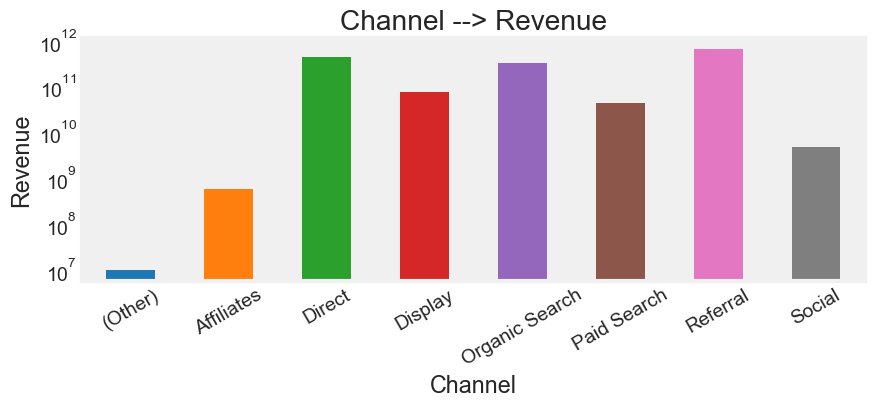

In [756]:
plt.figure(figsize=(9,3))
plt.style.use('fivethirtyeight')
train_df.groupby('channelGrouping')['totals.transactionRevenue'].sum().plot(kind='bar',logy=True)
plt.xticks(rotation=30)
plt.xlabel('Channel')
plt.ylabel('Revenue')
plt.title('Channel --> Revenue')
plt.savefig('channel_revenue')

Text(0.5,1,'Operation System-->Revenue')

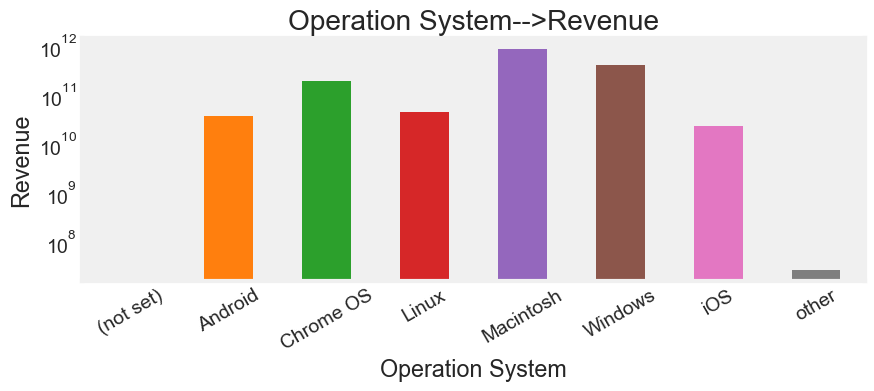

In [758]:
plt.figure(figsize=(9,3))
train_df.groupby('device.operatingSystem')['totals.transactionRevenue'].sum().plot(kind='bar',logy=True)
plt.xticks(rotation=30)
plt.xlabel('Operation System')
plt.ylabel('Revenue')
plt.title('Operation System-->Revenue')

Text(0.5,1,'Browser-->Revenue')

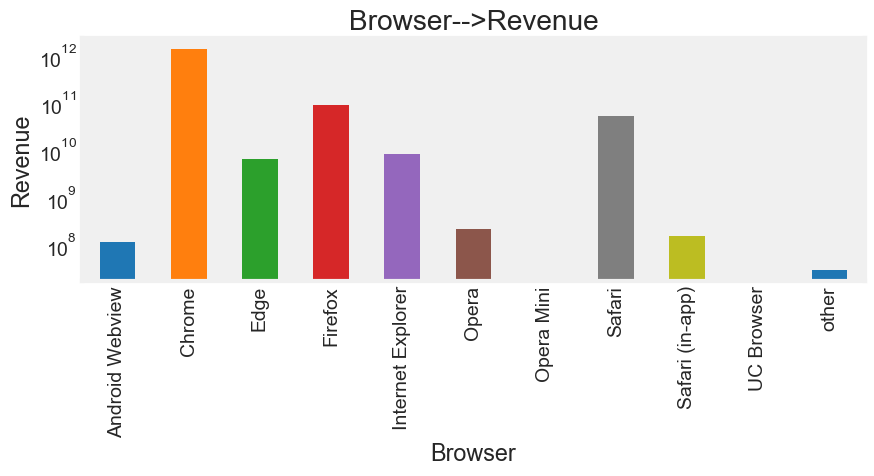

In [759]:
plt.figure(figsize=(9,3))
train_df.groupby('device.browser')['totals.transactionRevenue'].sum().plot(kind='bar',logy=True)
plt.xlabel('Browser')
plt.ylabel('Revenue')
plt.title('Browser-->Revenue')

Text(0.5,1,'Campaign-->Revenue')

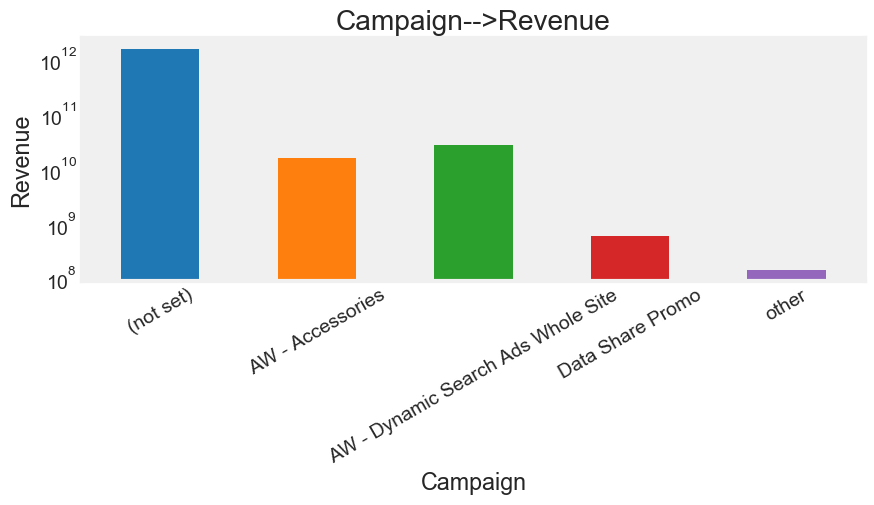

In [761]:
plt.figure(figsize=(9,3))
train_df.groupby('trafficSource.campaign')['totals.transactionRevenue'].sum().plot(kind='bar',logy=True)
plt.xticks(rotation=30)
plt.xlabel('Campaign')
plt.ylabel('Revenue')
plt.title('Campaign-->Revenue')

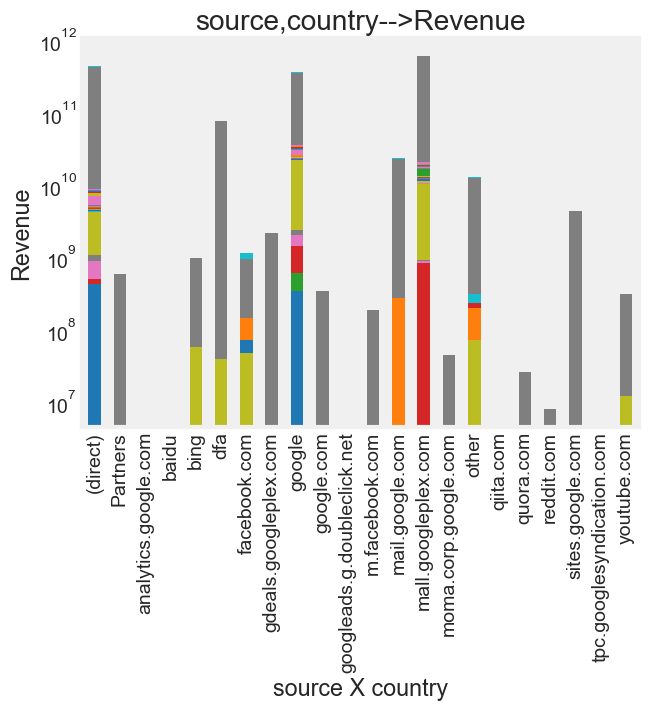

In [769]:
pd.pivot_table(train_df,columns='geoNetwork.country',
                    index='trafficSource.source',values='totals.transactionRevenue',aggfunc='sum').plot(kind='bar',stacked=True,logy=True)
plt.xlabel('source X country')
plt.ylabel('Revenue')
plt.title('source,country-->Revenue')
plt.legend(labels='')

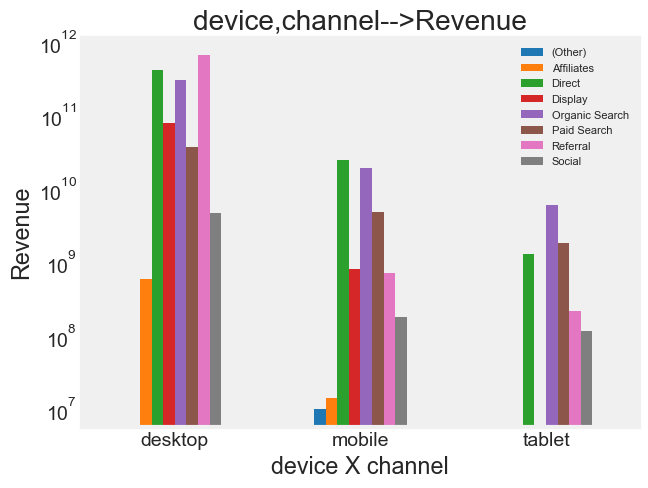

In [770]:
pd.pivot_table(train_df,index='device.r',columns='channelGrouping',
                    values='totals.transactionRevenue',aggfunc='sum').plot.bar(logy=True)
plt.xticks(rotation=0)
plt.xlabel('device X channel')
plt.ylabel('Revenue')
plt.title('device,channel-->Revenue')
plt.legend(labels='')
plt.legend(fontsize=8)

## Feature Engineering 

In [590]:
for df in [train_df,test_df]:
    df['source.country']=df['trafficSource.source']+'_'+df['geoNetwork.country']
    df['campaign.medium']=df['trafficSource.campaign']+'_'+df['trafficSource.medium']
    df['browser.category']=df['device.browser']+'_'+df['device.deviceCategory']
    df['browser.os']=df['device.browser']+'_'+df['device.operatingSystem']

In [591]:
for df in [train_df,test_df]:
    df['dev_deviceCategory_channelGrouping']=df['device.deviceCategory']+'_'+df['channelGrouping']
    df['channelGrouping_browser']=df['device.browser']+'_'+df['channelGrouping']
    df['channelGrouping_OS']=df['device.operatingSystem']+'_'+df['channelGrouping']
    
    for i in ['geoNetwork.city','geoNetwork.continent','geoNetwork.country','geoNetwork.metro','geoNetwork.networkDomain', 'geoNetwork.region','geoNetwork.subContinent']:
        for j in ['device.browser','device.deviceCategory', 'device.operatingSystem', 'trafficSource.source']:
            df[i+'_'+j]=df[i]+'_'+df[j]
    
    df['content.source']=df['trafficSource.adContent'].astype(str)+'_'+df['source.country']
    df['medium_source']=df['trafficSource.medium']+'_'+df['source.country']

In [592]:
train_id=train_df['fullVisitorId']
test_id=test_df['fullVisitorId']
train_df['totals.transactionRevenue']=train_df['totals.transactionRevenue'].astype('float').fillna(0)
train_y=train_df['totals.transactionRevenue']
train_target=np.log1p(train_df.groupby('fullVisitorId')['totals.transactionRevenue'].sum())

In [504]:
from sklearn.preprocessing import LabelEncoder

In [505]:
#將cateogrical資料轉成numerical資料
train_df.drop(['visitId'],axis=1,inplace=True)
test_df.drop(['visitId'],axis=1,inplace=True)
#train_df.drop(['fullVisitorId','sessionId','visitId'],axis=1,inplace=True)
num_col=['totals.hits','totals.pageviews','visitNumber','totals.bounces','totals.newVisits','visitStartTime']
for i in num_col:
    train_df[i]=train_df[i].astype('float')#.fillna(0)
    test_df[i]=test_df[i].astype('float')#.fillna(0)
cat_col=[e for e in train_df.columns.tolist() if e not in num_col]
cat_col.remove('date')
cat_col.remove('totals.transactionRevenue')
for i in cat_col:
    lab_en=LabelEncoder()
    #train_df[i]=train_df[i].fillna('Not Known')
    #test_df[i]=test_df[i].fillna('Not Known')
"""
記得要用train的資料來對test資料做label encoder
"""
    if i not in ['fullVisitorId' , 'sessionId']:
        lab_en.fit(list(train_df[i].astype('str'))+list(test_df[i].astype('str')))
        train_df[i]=lab_en.transform(list(train_df[i].astype('str')))
        test_df[i]=lab_en.transform(list(test_df[i].astype('str')))
    print('finish',i)

finish channelGrouping
finish fullVisitorId
finish sessionId
finish device.browser
finish device.deviceCategory
finish device.isMobile
finish device.operatingSystem
finish geoNetwork.city
finish geoNetwork.continent
finish geoNetwork.country
finish geoNetwork.metro
finish geoNetwork.networkDomain
finish geoNetwork.region
finish geoNetwork.subContinent
finish trafficSource.adContent
finish trafficSource.adwordsClickInfo.adNetworkType
finish trafficSource.adwordsClickInfo.gclId
finish trafficSource.adwordsClickInfo.isVideoAd
finish trafficSource.adwordsClickInfo.page
finish trafficSource.adwordsClickInfo.slot
finish trafficSource.campaign
finish trafficSource.isTrueDirect
finish trafficSource.keyword
finish trafficSource.medium
finish trafficSource.referralPath
finish trafficSource.source
finish source.country
finish campaign.medium
finish browser.category
finish browser.os
finish dev_deviceCategory_channelGrouping
finish channelGrouping_browser
finish channelGrouping_OS
finish geoNetwor

In [506]:
#因為原本為很長一串數字，將其定義為'秒'，會將其轉成日期型態
train_df.visitStartTime=pd.to_datetime(train_df.visitStartTime,unit='s')
test_df.visitStartTime=pd.to_datetime(test_df.visitStartTime,unit='s')
#用.dt. 找出你想要的日期
for df in [train_df,test_df]:
    df['weekday']=df['visitStartTime'].dt.dayofweek.astype(object)
    df['time']=df['visitStartTime'].dt.second+df['visitStartTime'].dt.minute*60+df['visitStartTime'].dt.hour*3600

In [507]:
y_train=np.log1p(train_df['totals.transactionRevenue'])
x_train=train_df.drop('totals.transactionRevenue',axis=1)
x_test=test_df.copy()
print(x_train.shape)
print(x_test.shape)

(903653, 72)
(804684, 72)


In [89]:
from datetime import datetime

In [96]:
train_df_new_copy=train_df_new.copy()
train_df_new['date']=train_df_new_copy['date'].apply(lambda x:datetime.strptime(str(x),'%Y%m%d'))

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

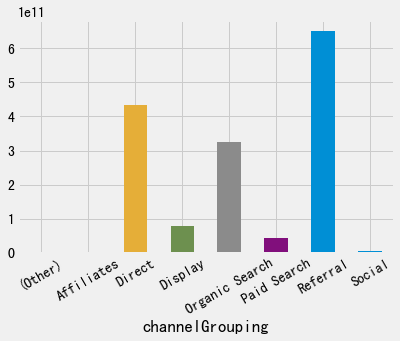

In [115]:
plt.style.use('fivethirtyeight')
train_df_new.groupby('channelGrouping')['totals.transactionRevenue'].sum().plot(kind='bar')
plt.xticks(rotation=30)

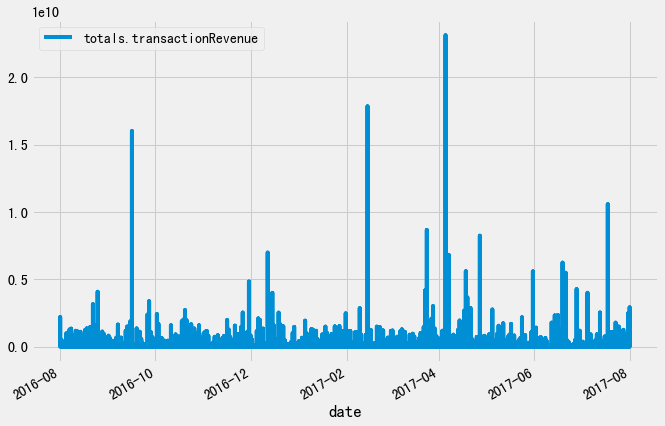

In [127]:
train_df_new.plot(x='date',y='totals.transactionRevenue',figsize=(10,7))

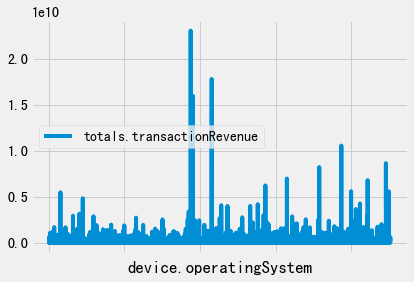

In [128]:
train_df_new.plot(x='device.operatingSystem',y='totals.transactionRevenue')

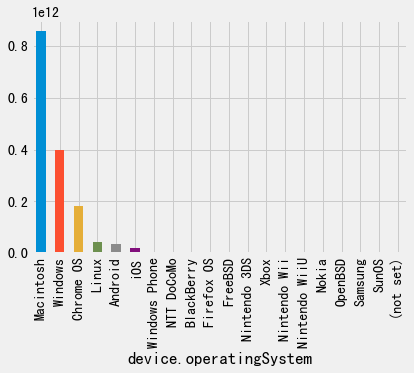

In [134]:
train_df_new.groupby('device.operatingSystem')['totals.transactionRevenue'].sum().sort_values(ascending=False).plot(kind='bar')

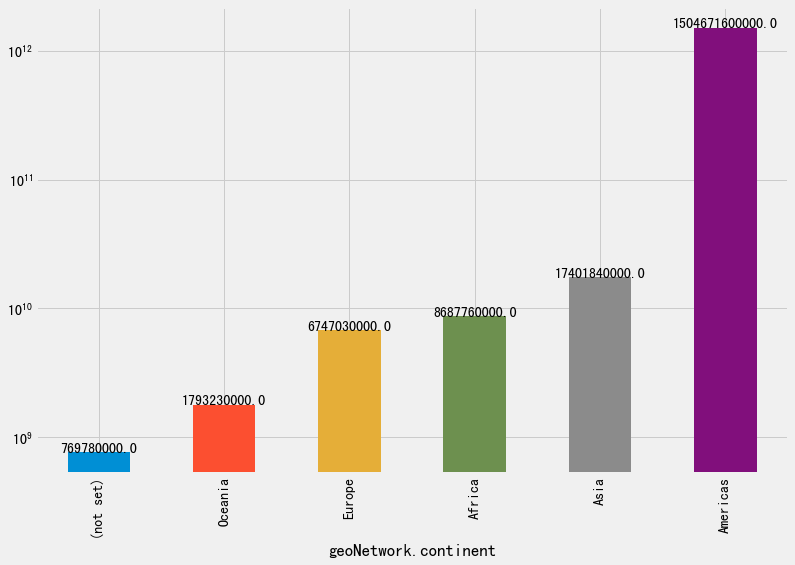

In [229]:
plt.figure(figsize=(12,8))
train_continent_revenue=train_df_new.groupby('geoNetwork.continent')['totals.transactionRevenue'].sum().sort_values()
train_continent_revenue.plot(kind='bar',logy=True)
for i in range(len(train_continent_revenue.index)):
    plt.text(x=i,y=train_continent_revenue.values[i],s=train_continent_revenue.values[i],ha='center')

(-0.5, 27.5, 9287436.241575394, 1441628801656.1116)

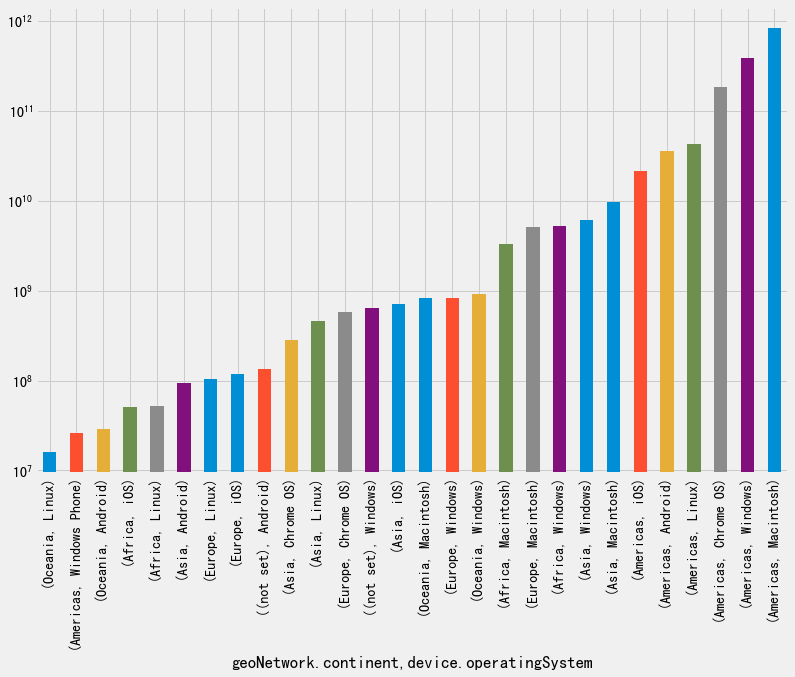

In [228]:
plt.figure(figsize=(12,8))
train_continent_operatingsystem=train_df_new.groupby(['geoNetwork.continent','device.operatingSystem'])['totals.transactionRevenue'].sum()
train_continent_operatingsystem_bigger=train_continent_operatingsystem[train_continent_operatingsystem>0].sort_values()
train_continent_operatingsystem_bigger.plot(kind='bar',logy=True)
plt.axis()
#for i in range(20):
  #  plt.text(x=i,y=train_continent_operatingsystem_bigger.values[i],s=np.log(train_continent_operatingsystem_bigger.values[i]),ha='center')

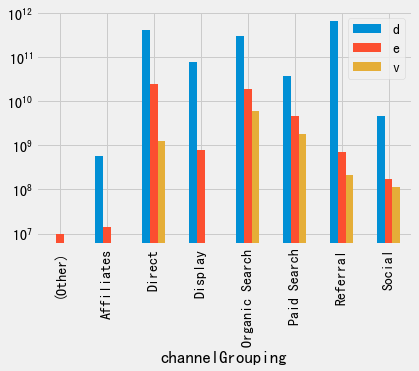

In [220]:
channel_device=pd.pivot_table(train_df_new,values='totals.transactionRevenue',index='channelGrouping',columns='device.deviceCategory',aggfunc='sum')
channel_device.plot(kind='bar',logy=True)

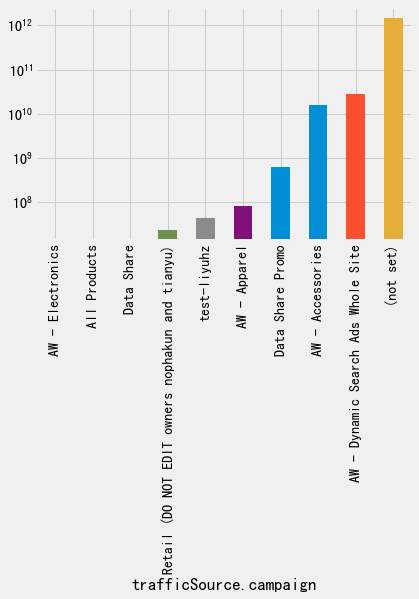

In [236]:
(train_df_new.groupby('trafficSource.campaign')['totals.transactionRevenue'].sum().sort_values()).plot(kind='bar',logy=True)

## Auto Feature Engineering  自動化特徵工程
進行訓練資料集的自動化特徵工程

In [23]:
"""因為檔案太大，所以分成好幾個檔案來分開處理，這樣可以提升效率"""
# Chunk size for 104 sections 分成104個file去做處理
chunk_size = len(x_train) // 103

# Create list of lists of clients in each section 
train_lists = [list(x_train.iloc[i:i+chunk_size].index) for i in range(0, len(x_train), chunk_size)]

#根據檔案來命名 第一個檔案救命名為p1
def create_partion(train_lists,parition_number):
    subset=x_train.iloc[train_lists]
    subset.to_csv('p%s.csv'%str(parition_number))

for i, ids in enumerate(train_lists):
    create_partion(ids,i)

In [188]:
train_df.head()

,channelGrouping,date,fullVisitorId,sessionId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,4,20160902,1131660440785968503,1131660440785968503_1472830385,1.0,1.472830e+09,35,0,0,20,378,3,210,0,37454,193,21,1.0,1.0,1.0,1.0,0.0,37,2,59008,1,11,1,4,0,11,5,3196,208
1,4,20160902,377306020877927890,377306020877927890_1472880147,1.0,1.472880e+09,43,0,0,7,955,5,12,122,10098,482,1,1.0,1.0,1.0,1.0,0.0,37,2,59008,1,11,1,4,0,11,5,3196,208
2,4,20160902,3895546263509774583,3895546263509774583_1472865386,1.0,1.472865e+09,35,0,0,20,475,4,185,0,38725,99,19,1.0,1.0,1.0,1.0,0.0,37,2,59008,1,11,1,4,0,11,5,3196,208
3,4,20160902,4763447161404445595,4763447161404445595_1472881213,1.0,1.472881e+09,79,0,0,6,955,3,94,122,38725,482,16,1.0,1.0,1.0,1.0,0.0,37,2,59008,1,11,1,4,0,1608,5,3196,208
4,4,20160902,27294437909732085,27294437909732085_1472822600,2.0,1.472823e+09,35,1,1,1,955,4,217,122,38725,482,13,1.0,1.0,0.0,1.0,0.0,37,2,59008,1,11,1,4,1,11,5,3196,208


In [14]:
#開始進行自動化特徵工程
import featuretools as ft
import os
#使用dask來操作
import dask.bag as db
from dask.distributed import Client
def entityset_from_partition(path):
    #Create an EntitySet from a partition of data
    x_train=pd.read_csv('%s' %path)
    parition_num=int(path[1:-4])

    visitor=['fullVisitorId','device.browser', 'device.deviceCategory', 'device.isMobile',
       'device.operatingSystem', 'geoNetwork.continent',
       'geoNetwork.country', 'geoNetwork.subContinent']

    session=['sessionId','fullVisitorId','visitNumber','totals.bounces',
       'totals.hits', 'totals.newVisits', 'totals.pageviews','geoNetwork.city','geoNetwork.metro','geoNetwork.networkDomain','geoNetwork.region']

    source=['sessionId','trafficSource.adContent','channelGrouping','visitStartTime',
        'trafficSource.adwordsClickInfo.adNetworkType',
        'trafficSource.adwordsClickInfo.gclId',
        'trafficSource.adwordsClickInfo.isVideoAd',
        'trafficSource.adwordsClickInfo.page',
        'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign',
        'trafficSource.isTrueDirect', 'trafficSource.keyword',
        'trafficSource.medium', 'trafficSource.referralPath',
        'trafficSource.source']
    
    visitor=x_train[visitor].drop_duplicates(subset='fullVisitorId')
    session=x_train[session].drop_duplicates(subset='sessionId')
    x_train['visitStartTime']=pd.to_datetime(x_train['visitStartTime'],unit='s')
    
    es=ft.EntitySet(id='df_featuretools')
    es=es.entity_from_dataframe(entity_id='visitor',dataframe=visitor,
                                    index='fullVisitorId')
    es=es.entity_from_dataframe(entity_id='session',dataframe=session,
                                    index='sessionId')
    es=es.entity_from_dataframe(entity_id='source',dataframe=x_train[source],
                                    make_index=True,index='source_id',time_index='visitStartTime')
    
    #Add relationships
    channel_stats=ft.Relationship(es['visitor']['fullVisitorId'],es['session']['fullVisitorId'])
    browser_stats=ft.Relationship(es['session']['sessionId'],es['source']['sessionId'])
    
    es=es.add_relationships([channel_stats,browser_stats])
    
    return ({'es':es,'num':parition_num})

In [15]:
es1_dict = entityset_from_partition('p100.csv')
es1_dict['es']

Entityset: df_featuretools
  Entities:
    visitor [Rows: 8152, Columns: 8]
    session [Rows: 8773, Columns: 11]
    source [Rows: 8773, Columns: 16]
  Relationships:
    session.fullVisitorId -> visitor.fullVisitorId
    source.sessionId -> session.sessionId

In [16]:
def feature_matrix_from_entityset(es_dict,return_fm=False):
    es=es_dict['es']
    
    feature_matrix,feature_names=ft.dfs(entityset=es,target_entity='source'
                                   ,max_depth=2,verbose =1,n_jobs=1)
    feature_matrix.to_csv('p%d_fm.csv' %es_dict['num'],index=True)
    
    if return_fm:
        return feature_matrix

In [17]:
client=Client(processes=True)
#檢測有幾個core在運作
print(client.ncores())
#看看有多
paths=['p%d.csv' %i for i in range(0,104) ]
print(paths[:8])

{'tcp://127.0.0.1:55847': 1, 'tcp://127.0.0.1:55848': 1, 'tcp://127.0.0.1:55845': 1, 'tcp://127.0.0.1:55846': 1}
['p0.csv', 'p1.csv', 'p2.csv', 'p3.csv', 'p4.csv', 'p5.csv', 'p6.csv', 'p7.csv']


In [18]:
#Create a bag object
b=db.from_sequence(paths)
#Map entitysetset function
b=b.map(entityset_from_partition)
#Map feature matrix function
b=b.map(feature_matrix_from_entityset)
print(b)

dask.bag<map-fea..., npartitions=104>


In [19]:
#計算運作的時間
from timeit import default_timer as timer

overall_start=timer()
b.compute()
overall_end=timer()

print(round(overall_end-overall_start,2))

2095.61


In [4]:
from timeit import default_timer as timer
base='/Users/jacky/Kaggle/Google Analytics Customer Revenue Prediction'
#fm_train_path=[p for p in os.listdir(base) if 'fm.csv' in p]# if 'train' in p]
#fm_train_path=[p for index,p in enumerate(os.listdir(base)) if 'fm.csv' in p if index==int(p[1:-7]) ]
#fm_test_path=[p for p in os.listdir(base) if 'fm.csv' in p if 'test' in p]
fm_train_path=[]
for index in range(0,104):
    for p in os.listdir(base):
        if 'fm.csv' in p:
            if 'test' not in p:
                if index==int(p[1:-7]):
                    fm_train_path.append(p)
read_start=timer()
fms_train=[pd.read_csv(path) for path in fm_train_path]
#fms_test=[pd.read_csv(path) for path in fm_test_path]
read_end=timer()

In [5]:
x_train=pd.concat(fms_train,axis=0)

In [6]:
x_train.drop('sessionId',axis=1,inplace=True)
x_train.set_index('session.fullVisitorId',inplace=True)

In [8]:
x_train_new=x_train.drop('source_id',axis=1)

In [168]:
x_train.head()

,source_id,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.isTrueDirect,trafficSource.source,trafficSource.adwordsClickInfo.slot,trafficSource.keyword,trafficSource.medium,trafficSource.campaign,trafficSource.adContent,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.page,trafficSource.referralPath,channelGrouping,session.totals.hits,WEEKDAY(visitStartTime),session.totals.newVisits,session.geoNetwork.metro,DAY(visitStartTime),session.geoNetwork.city,session.totals.bounces,MONTH(visitStartTime),YEAR(visitStartTime),session.visitNumber,session.geoNetwork.region,session.geoNetwork.networkDomain,session.totals.pageviews,session.SKEW(source.trafficSource.adwordsClickInfo.gclId),session.MEAN(source.trafficSource.adwordsClickInfo.page),session.SKEW(source.trafficSource.medium),session.MEAN(source.trafficSource.adwordsClickInfo.gclId),session.MAX(source.trafficSource.keyword),session.MAX(source.trafficSource.adwordsClickInfo.gclId),session.MEAN(source.trafficSource.adwordsClickInfo.adNetworkType),session.MEAN(source.trafficSource.adContent),session.visitor.device.operatingSystem,session.STD(source.trafficSource.campaign),session.STD(source.channelGrouping),session.SKEW(source.trafficSource.adContent),session.COUNT(source),session.MEAN(source.trafficSource.isTrueDirect),session.MEAN(source.trafficSource.keyword),session.STD(source.trafficSource.adwordsClickInfo.isVideoAd),session.MIN(source.trafficSource.campaign),session.SKEW(source.trafficSource.adwordsClickInfo.isVideoAd),session.MAX(source.trafficSource.adwordsClickInfo.adNetworkType),session.SKEW(source.trafficSource.campaign),session.SUM(source.trafficSource.adwordsClickInfo.isVideoAd),session.MEAN(source.trafficSource.source),session.MIN(source.trafficSource.adwordsClickInfo.isVideoAd),session.MEAN(source.trafficSource.adwordsClickInfo.isVideoAd),session.MIN(source.trafficSource.isTrueDirect),session.MIN(source.trafficSource.adwordsClickInfo.adNetworkType),session.SUM(source.trafficSource.source),session.MEAN(source.trafficSource.campaign),session.visitor.device.browser,session.SKEW(source.trafficSource.referralPath),session.STD(source.trafficSource.adContent),session.MAX(source.trafficSource.adwordsClickInfo.isVideoAd),session.SUM(source.trafficSource.keyword),session.MEAN(source.trafficSource.medium),session.STD(source.trafficSource.adwordsClickInfo.gclId),session.MIN(source.trafficSource.referralPath),session.visitor.device.deviceCategory,session.visitor.geoNetwork.country,session.SKEW(source.channelGrouping),session.STD(source.trafficSource.referralPath),session.STD(source.trafficSource.medium),session.STD(source.trafficSource.adwordsClickInfo.adNetworkType),session.SUM(source.trafficSource.adwordsClickInfo.gclId),session.STD(source.trafficSource.adwordsClickInfo.slot),session.SUM(source.trafficSource.adContent),session.MIN(source.trafficSource.adwordsClickInfo.page),session.SKEW(source.trafficSource.adwordsClickInfo.adNetworkType),session.SUM(source.trafficSource.campaign),session.MEAN(source.trafficSource.adwordsClickInfo.slot),session.MAX(source.trafficSource.isTrueDirect),session.SUM(source.trafficSource.isTrueDirect),session.MEAN(source.channelGrouping),session.SUM(source.trafficSource.adwordsClickInfo.adNetworkType),session.visitor.geoNetwork.subContinent,session.SUM(source.trafficSource.referralPath),session.STD(source.trafficSource.source),session.MIN(source.trafficSource.adContent),session.SKEW(source.trafficSource.keyword),session.MAX(source.trafficSource.adwordsClickInfo.slot),session.SKEW(source.trafficSource.source),session.STD(source.trafficSource.keyword),session.MAX(source.trafficSource.source),session.MAX(source.trafficSource.campaign),session.MIN(source.trafficSource.source),session.MIN(source.trafficSource.medium),session.SUM(source.trafficSource.medium),session.STD(source.trafficSource.adwordsClickInfo.page),session.MAX(source.trafficSource.referralPath),session.MAX(source.trafficSourc

## Feature Selection 特徵選擇 

In [87]:
from feature_selector import FeatureSelector

In [70]:
y_train=np.log1p(train_y)

In [454]:
fs=FeatureSelector(data=x_train,labels=y_train)

In [455]:
fs.identify_missing(0.6)

0 features with greater than 0.60 missing values.



In [456]:
fs.record_missing.head()

,feature,missing_fraction


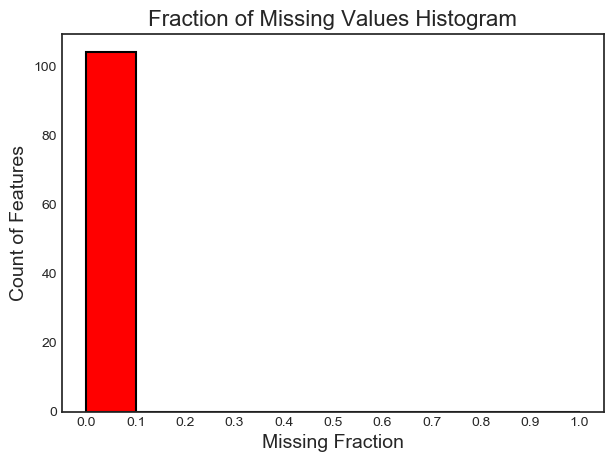

In [457]:
fs.plot_missing()

In [458]:
fs.identify_collinear(0.99)

43 features with a correlation magnitude greater than 0.99.



In [459]:
fs.ops['collinear']

['trafficSource.adwordsClickInfo.isVideoAd',
 'trafficSource.adwordsClickInfo.slot',
 'source.country',
 'browser.category',
 'browser.os',
 'channelGrouping_browser',
 'geoNetwork.city_device.browser',
 'geoNetwork.city_device.deviceCategory',
 'geoNetwork.city_device.operatingSystem',
 'geoNetwork.city_trafficSource.source',
 'geoNetwork.country_device.browser',
 'geoNetwork.country_device.deviceCategory',
 'geoNetwork.country_device.operatingSystem',
 'geoNetwork.country_trafficSource.source',
 'geoNetwork.metro_device.browser',
 'geoNetwork.metro_device.deviceCategory',
 'geoNetwork.metro_device.operatingSystem',
 'geoNetwork.metro_trafficSource.source',
 'geoNetwork.networkDomain_device.browser',
 'geoNetwork.networkDomain_device.deviceCategory',
 'geoNetwork.networkDomain_device.operatingSystem',
 'geoNetwork.networkDomain_trafficSource.source',
 'geoNetwork.region_device.browser',
 'geoNetwork.region_device.deviceCategory',
 'geoNetwork.region_device.operatingSystem',
 'geoNetwo

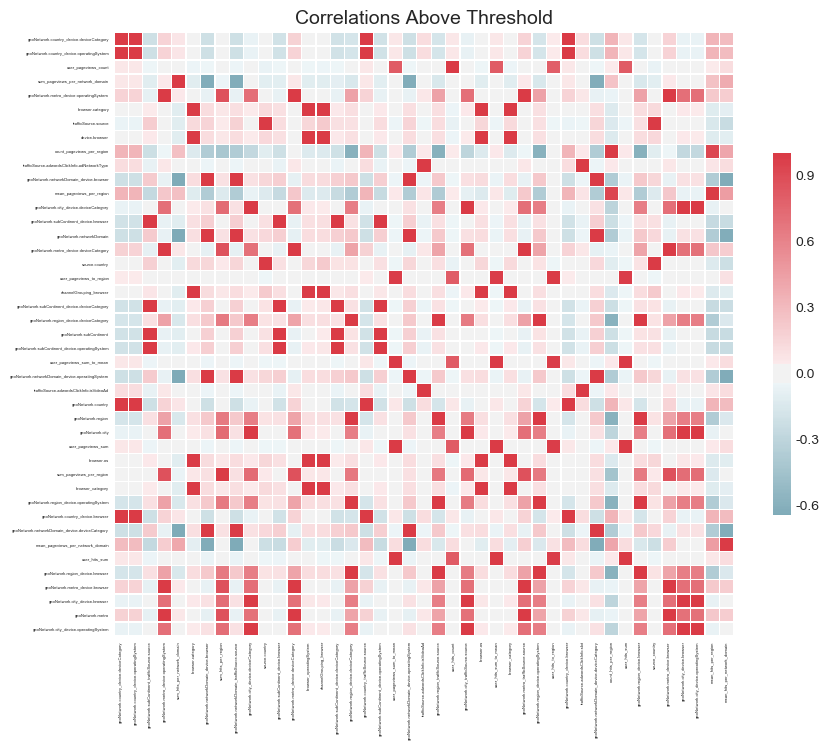

In [460]:
fs.plot_collinear()

In [331]:
fs.identify_zero_importance(task='regression',
                            eval_metric='l2',
                            n_iterations=10,
                            early_stopping=True)

['channelGrouping', 'date', 'visitNumber', 'device.browser', 'device.deviceCategory', 'device.isMobile', 'device.operatingSystem', 'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region', 'geoNetwork.subContinent', 'totals.bounces', 'totals.hits', 'totals.newVisits', 'totals.pageviews', 'trafficSource.adContent', 'trafficSource.adwordsClickInfo.adNetworkType', 'trafficSource.adwordsClickInfo.gclId', 'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.adwordsClickInfo.page', 'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign', 'trafficSource.isTrueDirect', 'trafficSource.keyword', 'trafficSource.medium', 'trafficSource.referralPath', 'trafficSource.source', 'source.country', 'campaign.medium', 'browser.category', 'browser.os', 'dev_deviceCategory_channelGrouping', 'channelGrouping_browser', 'channelGrouping_OS', 'geoNetwork.city_device.browser', 'geoNetwork.city_device.deviceCategory', 'geoNe

In [332]:
zero_importance_features = fs.ops['zero_importance']
zero_importance_features

['totals.bounces',
 'trafficSource.adwordsClickInfo.isVideoAd',
 'trafficSource.adwordsClickInfo.page']

In [333]:
fs.identify_low_importance(cumulative_importance=0.99)

50 features required for cumulative importance of 0.99 after one hot encoding.
19 features do not contribute to cumulative importance of 0.99.



In [334]:
fs.record_low_importance.head()

,feature,importance,normalized_importance,cumulative_importance
50,browser.category,21.0,0.001697,0.991089
51,geoNetwork.country,20.5,0.001656,0.992745
52,trafficSource.medium,19.2,0.001551,0.994296
53,trafficSource.source,18.7,0.001511,0.995807
54,trafficSource.campaign,12.8,0.001034,0.996841


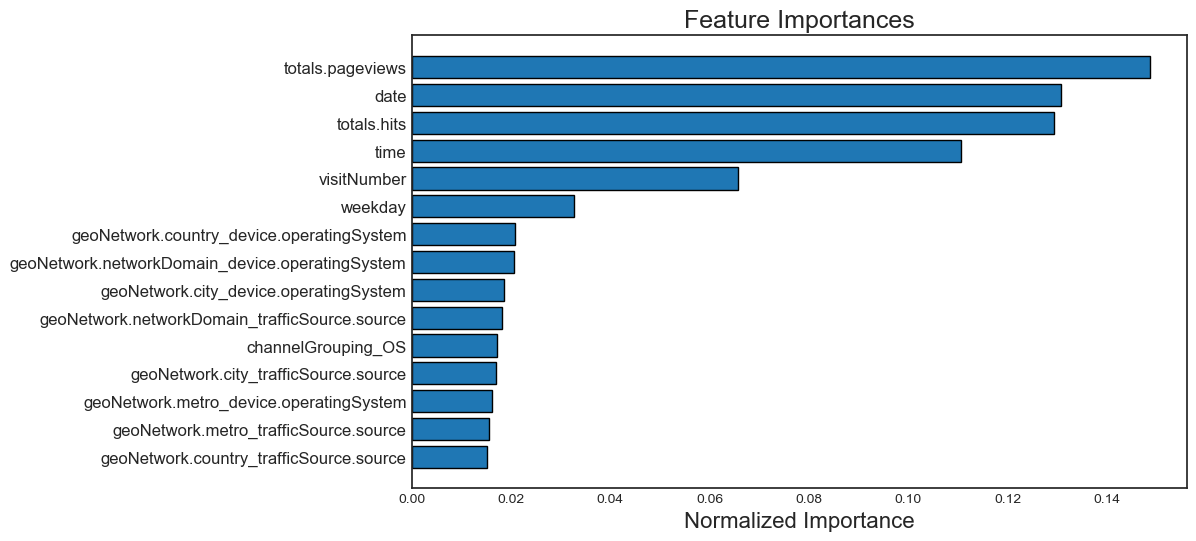

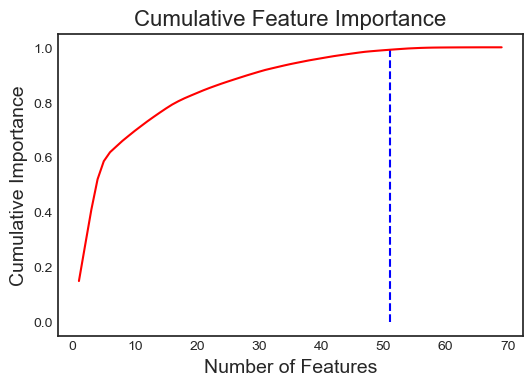

51 features required for 0.99 of cumulative importance


In [335]:
fs.plot_feature_importances(threshold = 0.99, plot_n = 15)

In [336]:
fs.feature_importances.sort_values(by='cumulative_importance').head(21)

,feature,importance,normalized_importance,cumulative_importance
0,totals.pageviews,1839.9,0.148643,0.148643
1,date,1618.5,0.130756,0.279399
2,totals.hits,1602.5,0.129464,0.408862
3,time,1368.6,0.110567,0.519430
4,visitNumber,814.1,0.065770,0.585200
5,weekday,403.6,0.032606,0.617806
6,geoNetwork.country_device.operatingSystem,257.7,0.020819,0.638625
7,geoNetwork.networkDomain_device.operatingSystem,255.0,0.020601,0.659226
8,geoNetwork.city_device.operatingSystem,229.1,0.018509,0.677735
9,geoNetwork.networkDomain_trafficSource.source,225.7,0.018234,0.695969


In [338]:
fs.record_low_importance.head()

,feature,importance,normalized_importance,cumulative_importance
50,browser.category,21.0,0.001697,0.991089
51,geoNetwork.country,20.5,0.001656,0.992745
52,trafficSource.medium,19.2,0.001551,0.994296
53,trafficSource.source,18.7,0.001511,0.995807
54,trafficSource.campaign,12.8,0.001034,0.996841


In [461]:
train_removed=fs.remove(methods=[ 'collinear', 'missing'])

Removed 43 features.


In [353]:
fs.ops['low_importance']

['browser.category',
 'geoNetwork.country',
 'trafficSource.medium',
 'trafficSource.source',
 'trafficSource.campaign',
 'geoNetwork.subContinent_device.deviceCategory',
 'campaign.medium',
 'device.browser',
 'geoNetwork.continent',
 'geoNetwork.subContinent',
 'device.deviceCategory',
 'trafficSource.adwordsClickInfo.adNetworkType',
 'trafficSource.adContent',
 'trafficSource.adwordsClickInfo.slot',
 'totals.newVisits',
 'device.isMobile',
 'totals.bounces',
 'trafficSource.adwordsClickInfo.isVideoAd',
 'trafficSource.adwordsClickInfo.page']

In [509]:
x_train.set_index('fullVisitorId',inplace=True)
x_test.set_index('fullVisitorId',inplace=True)

x_train.drop('sessionId',axis=1,inplace=True)
x_test.drop('sessionId',axis=1,inplace=True)

x_train.drop('visitStartTime',axis=1,inplace=True)
x_test.drop('visitStartTime',axis=1,inplace=True)
x_train['weekday']=x_train['weekday'].astype('int')
x_test['weekday']=x_test['weekday'].astype('int')

In [20]:
y_train=np.log1p(train_df['totals.transactionRevenue'])
y_train=y_train.fillna(0)

## 根據測試資料集的自動化特徵工程
跟train資料集是一樣的操作

In [195]:
# Chunk size for 104 sections
chunk_size = len(x_test) // 103

# Create list of lists of clients in each section
test_lists = [list(x_test.iloc[i:i+chunk_size].index) for i in range(0, len(x_test), chunk_size)]

def create_partion(test_lists,parition_number):
    subset=x_test.iloc[test_lists]
    subset.to_csv('ptest%s.csv'%str(parition_number))

for i, ids in enumerate(test_lists):
    create_partion(ids,i)

In [198]:
import featuretools as ft
import os
import dask.bag as db
from dask.distributed import Client
def entityset_from_partition(path):
    #Create an EntitySet from a partition of data
    x_test=pd.read_csv('%s' %path)
    parition_num=int(path[5:-4])

    visitor=['fullVisitorId','device.browser', 'device.deviceCategory', 'device.isMobile',
       'device.operatingSystem', 'geoNetwork.continent',
       'geoNetwork.country', 'geoNetwork.subContinent']

    session=['sessionId','fullVisitorId','visitNumber','totals.bounces',
       'totals.hits', 'totals.newVisits', 'totals.pageviews','geoNetwork.city','geoNetwork.metro','geoNetwork.networkDomain','geoNetwork.region']

    source=['sessionId','trafficSource.adContent','channelGrouping','visitStartTime',
        'trafficSource.adwordsClickInfo.adNetworkType',
        'trafficSource.adwordsClickInfo.gclId',
        'trafficSource.adwordsClickInfo.isVideoAd',
        'trafficSource.adwordsClickInfo.page',
        'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign',
        'trafficSource.isTrueDirect', 'trafficSource.keyword',
        'trafficSource.medium', 'trafficSource.referralPath',
        'trafficSource.source']
    
    visitor=x_test[visitor].drop_duplicates(subset='fullVisitorId')
    session=x_test[session].drop_duplicates(subset='sessionId')
    x_test['visitStartTime']=pd.to_datetime(x_test['visitStartTime'],unit='s')
    
    es=ft.EntitySet(id='df_featuretools')
    es=es.entity_from_dataframe(entity_id='visitor',dataframe=visitor,
                                    index='fullVisitorId')
    es=es.entity_from_dataframe(entity_id='session',dataframe=session,
                                    index='sessionId')
    es=es.entity_from_dataframe(entity_id='source',dataframe=x_test[source],
                                    make_index=True,index='source_id',time_index='visitStartTime')
    
    #Add relationships
    channel_stats=ft.Relationship(es['visitor']['fullVisitorId'],es['session']['fullVisitorId'])
    browser_stats=ft.Relationship(es['session']['sessionId'],es['source']['sessionId'])
    
    es=es.add_relationships([channel_stats,browser_stats])
    
    return ({'es':es,'num':parition_num})

In [199]:
es1_dict = entityset_from_partition('ptest10.csv')
es1_dict['es']

Entityset: df_featuretools
  Entities:
    source [Rows: 7812, Columns: 16]
    session [Rows: 7809, Columns: 11]
    visitor [Rows: 7236, Columns: 8]
  Relationships:
    session.fullVisitorId -> visitor.fullVisitorId
    source.sessionId -> session.sessionId

In [200]:
def feature_matrix_from_entityset(es_dict,return_fm=False):
    es=es_dict['es']
    
    feature_matrix_test,feature_names=ft.dfs(entityset=es,target_entity='source'
                                   ,max_depth=2,verbose =1,n_jobs=1)
    feature_matrix_test.to_csv('ptest%d_fm.csv' %es_dict['num'],index=True)
    
    if return_fm:
        return feature_matrix_test

In [201]:
client=Client(processes=True)
#檢測有幾個core在運作
print(client.ncores())
#看看有多
paths=['ptest%d.csv' %i for i in range(0,104) ]
print(paths[:8])

{'tcp://127.0.0.1:51154': 1, 'tcp://127.0.0.1:51157': 1, 'tcp://127.0.0.1:51156': 1, 'tcp://127.0.0.1:51155': 1}
['ptest0.csv', 'ptest1.csv', 'ptest2.csv', 'ptest3.csv', 'ptest4.csv', 'ptest5.csv', 'ptest6.csv', 'ptest7.csv']


In [202]:
#Create a bag object
b=db.from_sequence(paths)
#Map entitysetset function
b=b.map(entityset_from_partition)
#Map feature matrix function
b=b.map(feature_matrix_from_entityset)
print(b)

dask.bag<map-fea..., npartitions=104>


In [203]:
#計算運作的時間
from timeit import default_timer as timer

overall_start=timer()
b.compute()
overall_end=timer()

print(round(overall_end-overall_start,2))

1778.66


In [26]:
fm_test_path=[]
for index in range(0,104):
    for p in os.listdir(base):
        if '_fm.csv' in p:
            if 'test' in p:
                if index==int(p[5:-7]):
                    fm_test_path.append(p)
#a.append(int(p[1:-7]))
#if sorted(int())

In [27]:
from timeit import default_timer as timer
base='/Users/jacky/Kaggle/Google Analytics Customer Revenue Prediction'
#fm_train_path=[p for p in os.listdir(base) if 'fm.csv' in p]# if 'train' in p]
#fm_train_path=[p for index,p in enumerate(os.listdir(base)) if 'fm.csv' in p if index==int(p[1:-7]) ]
#fm_test_path=[p for p in os.listdir(base) if 'fm.csv' in p if 'test' in p]
read_start=timer()
#fms_train=[pd.read_csv(path) for path in fm_train_path]
fms_test=[pd.read_csv(path) for path in fm_test_path]
read_end=timer()

In [76]:
x_test=pd.concat(fms_test,axis=0)
x_test.drop('sessionId',axis=1,inplace=True)
x_test.set_index('session.fullVisitorId',inplace=True)
x_test_new=x_test.drop('source_id',axis=1)

In [77]:
x_test_new=x_test_new.reindex(columns=x_train_new.columns)
test_removed=x_test_new[train_removed.columns]

## 建立模型
使用light gradient boosting來建立預測模型

In [512]:
folds=KFold(n_splits=5,random_state=42)
oof_preds=np.zeros(x_train.shape[0])
sub_preds=np.zeros(x_test.shape[0])

start=time.time()
valid_score=0
for n_fold, (trn_idx,val_idx) in enumerate(folds.split(x_train,y_train)):
        trn_x,trn_y=x_train.iloc[trn_idx],y_train[trn_idx]
        val_x,val_y=x_train.iloc[val_idx],y_train[val_idx]
        
        train_data=lgb.Dataset(data=trn_x,label=trn_y)
        valid_data=lgb.Dataset(data=val_x,label=val_y)
        
"""本身lgb並沒有classification或regression的語法，所以要在params裡面去特別敘述，有可以挑選評估的方法"""
        params={'objective':'regression','metric':'rmse','n_estimators':10000,'early_stopping_rounds':100,
                'num_leaves':30,'learning_rate':0.01,'bagging_fraction':0.7,
                'feature_fraction':0.5,'min_child_samples':100,'subsample':0.9,'colsample_bytree':0.9}
        
        lgb_model=lgb.train(params,train_data,valid_sets=[train_data,valid_data],verbose_eval=1000)
        
        #val_idx 根據k_fold區分出來的index來放入自己預測的
        oof_preds[val_idx] = lgb_model.predict(val_x, num_iteration=lgb_model.best_iteration)
        oof_preds[oof_preds<0] = 0
        sub_pred = lgb_model.predict(x_test, num_iteration=lgb_model.best_iteration) / folds.n_splits
        sub_pred[sub_pred<0] = 0 # should be greater or equal to 0
        sub_preds += sub_pred
        print('Fold %2d RMSE : %.6f' % (n_fold + 1, np.sqrt(mean_squared_error(val_y, oof_preds[val_idx]))))
        valid_score += np.sqrt(mean_squared_error(val_y, oof_preds[val_idx]))

Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 1.57751	valid_1's rmse: 1.61626
[2000]	training's rmse: 1.53653	valid_1's rmse: 1.60644
[3000]	training's rmse: 1.50749	valid_1's rmse: 1.60384
Early stopping, best iteration is:
[3487]	training's rmse: 1.49567	valid_1's rmse: 1.60356
Fold  1 RMSE : 1.602356
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 1.57896	valid_1's rmse: 1.60152
[2000]	training's rmse: 1.53717	valid_1's rmse: 1.59603
Early stopping, best iteration is:
[1914]	training's rmse: 1.53996	valid_1's rmse: 1.59601
Fold  2 RMSE : 1.595154
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 1.56731	valid_1's rmse: 1.64775
[2000]	training's rmse: 1.52484	valid_1's rmse: 1.64238
Early stopping, best iteration is:
[1958]	training's rmse: 1.52601	valid_1's rmse: 1.64231
Fold  3 RMSE : 1.640704
Training until validation scores don't improve for 100 rounds.
[1000]	trai

In [322]:
train_idx=train_df.fullVisitorId
test_idx=test_df.fullVisitorId

In [513]:
"""
session-level 和 user-level 差別是指 
session-level:是指在工作階段中計算出來的rmse
user-level:一起進行總計算
"""
print('Session-level CV-score:', str(round(valid_score/folds.n_splits, 4)))
print(' ')
train_pred = pd.DataFrame({"fullVisitorId": train_idx})
train_pred["PredictedLogRevenue"] = np.expm1(oof_preds)
train_pred = train_pred.groupby("fullVisitorId")[
    "PredictedLogRevenue"].sum().reset_index()
train_pred.columns = ["fullVisitorId", "PredictedLogRevenue"]
train_pred["PredictedLogRevenue"] = np.log1p(train_pred["PredictedLogRevenue"])
train_rmse = np.sqrt(mean_squared_error(
    train_target, train_pred['PredictedLogRevenue']))
print('User-level score:', str(round(train_rmse, 4)))
print(' ')
end = time.time()
print('training time:', str(round((end - start)/60)), 'mins')

Session-level CV-score: 1.6112
 
User-level score: 1.5977
 
training time: 25 mins


In [514]:
test_pred = pd.DataFrame({"fullVisitorId":test_df_test.fullVisitorId})
test_pred["PredictedLogRevenue"] = np.expm1(sub_preds)
test_pred = test_pred.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
test_pred.columns = ["fullVisitorId", "PredictedLogRevenue"]
test_pred["PredictedLogRevenue"] = np.log1p(test_pred["PredictedLogRevenue"])
test_pred.to_csv("lgb_base_model_new.csv", index=False) # submission

In [364]:
test_pred.shape

(617242, 2)

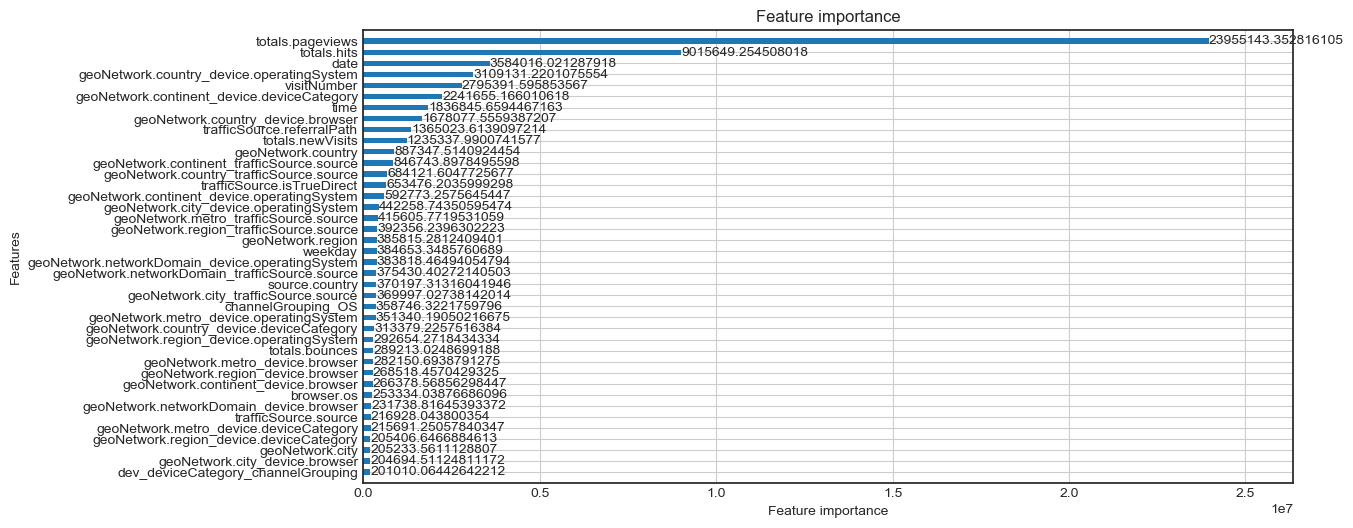

In [368]:
lgb.plot_importance(lgb_model,height=0.5,max_num_features=40,ignore_zero=False,figsize=(12,6),importance_type='gain')
plt.show()

## 建立自動化的找尋最佳超參數 

In [178]:
import csv
from hyperopt import STATUS_OK
from timeit import default_timer as timer
MAX_EVALS = 500
N_FOLDS = 10

train_set = lgb.Dataset(train_removed,label = y_train)

def objective(params, n_folds = N_FOLDS):
    """Objective function for Gradient Boosting Machine Hyperparameter Optimization"""
    
    # Keep track of evals
    global ITERATION
    
    ITERATION += 1
    
    # Retrieve the subsample if present otherwise set to 1.0
    #dict的get :是指如果沒有獲得subsample就回傳1.0
    subsample = params['boosting_type'].get('subsample', 1.0)
    
    # Extract the boosting type
    params['boosting_type'] = params['boosting_type']['boosting_type']
    params['subsample'] = subsample
    
    # Make sure parameters that need to be integers are integers
    for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_child_samples']:
        params[parameter_name] = int(params[parameter_name])
    
    start = timer()
    
    # Perform n_folds cross validation
    cv_results = lgb.cv(params, train_set, num_boost_round = 10000, nfold = n_folds,
                        early_stopping_rounds = 100, metrics = 'rmse', stratified=False,seed = 50)
    
    run_time = timer() - start
    
    # Extract the best score
    best_score = np.max(cv_results['rmse-mean'])
    
    # Loss must be minimized
    loss = 1 - best_score
    
    # Boosting rounds that returned the highest cv score
    n_estimators = int(np.argmax(cv_results['rmse-mean']) + 1)

    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, params, ITERATION, n_estimators, run_time])
    
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'iteration': ITERATION,
            'estimators': n_estimators, 
            'train_time': run_time, 'status': STATUS_OK}

In [179]:
from hyperopt import hp
from hyperopt.pyll.stochastic import sample

# Define the search space
"""
hp.choice :指在objective隨機選取
hp.uniform:只在bagging_fraction 任意選取
hp.quniform:参数的取值是round(uniform(low,high)/q)*q
hp.loguniform:變量的取值範圍是[exp(low),exp(high)]
"""
space = {
    'objective':hp.choice('objective',['regression']),
    'bagging_fraction':hp.uniform('bagging_fraction',0.0,1.0),
    'feature_fraction':hp.uniform('feature_fraction',0.0,1.0),
    'class_weight': hp.choice('class_weight', [None, 'balanced']),
    #隨機choice一個，再從subsample裡面均勻分布取一個
    'boosting_type': hp.choice('boosting_type', [{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}, 
                                                 {'boosting_type': 'dart', 'subsample': hp.uniform('dart_subsample', 0.5, 1)},
                                                 {'boosting_type': 'goss', 'subsample': 1.0}]),
    'num_leaves': hp.quniform('num_leaves', 30, 150, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0)
}

In [180]:
#隨機取一個看看

# Sample from the full space
x = sample(space)

# Conditional logic to assign top-level keys
subsample = x['boosting_type'].get('subsample', 1.0)
x['boosting_type'] = x['boosting_type']['boosting_type']
x['subsample'] = subsample

x

{'bagging_fraction': 0.8147678206970072,
 'boosting_type': 'dart',
 'class_weight': 'balanced',
 'colsample_bytree': 0.9649196375195351,
 'feature_fraction': 0.15838413208979896,
 'learning_rate': 0.029008322290339828,
 'min_child_samples': 375.0,
 'num_leaves': 118.0,
 'objective': 'regression',
 'reg_alpha': 0.09768613709770835,
 'reg_lambda': 0.7915954234091565,
 'subsample': 0.7143671109102099,
 'subsample_for_bin': 220000.0}

In [181]:
from hyperopt import tpe

# optimization algorithm
tpe_algorithm = tpe.suggest

In [182]:
from hyperopt import Trials

# Keep track of results
bayes_trials = Trials()

In [183]:
# File to save first results
out_file = 'gbm_trials.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'iteration', 'estimators', 'train_time'])
of_connection.close()